# Identification of Invasive Ductal Carcinoma Breast Cancer In Histopathological Images: Deep Learning Approach

### **Overview of the Dataset: Breast Histopathology Images**

#### **1. Dataset Context**
- **Purpose**: The dataset is used for identifying *Invasive Ductal Carcinoma (IDC)*, the most common subtype of breast cancer. Accurate identification of IDC regions within histopathology slides is critical for clinical diagnosis and grading of cancer aggressiveness.
- **Source**: The data was originally derived from 162 whole mount slide images of breast cancer specimens scanned at 40x magnification.

---

#### **2. Dataset Content**
- **Structure**: The dataset contains **277,524 image patches**, each of size **50 x 50 pixels**.
  - **IDC Negative**: 198,738 images (no cancer detected).
  - **IDC Positive**: 78,786 images (cancer detected).
- **Image Naming Convention**:
  - Each image file name follows this format:  
    `patientID_xX_yY_classC.png`  
    Example: `10253_idx5_x1351_y1101_class0.png`.
    - `patientID`: Patient identifier (e.g., `10253_idx5`).
    - `xX` and `yY`: Coordinates from the original slide.
    - `classC`: Classification where `C = 0` (negative) or `C = 1` (positive).

---

#### **3. Dataset Details**
- **Size**: The dataset contains a total of **277,524 files**.
- **Resolution**: Each patch is fixed at **50 x 50 pixels**.
- **Categories**:
  - **IDC Positive** (Class `1`): Regions with invasive ductal carcinoma.
  - **IDC Negative** (Class `0`): Regions without carcinoma.

---

#### **4. Dataset Purpose and Use Cases**
- **Applications**:
  - Training machine learning models for cancer detection.
  - Developing image classification algorithms.
  - Conducting research on automated pathology diagnosis.
- **Challenges**:
  - Handling the class imbalance (IDC-negative samples dominate).
  - Managing duplicate files and ensuring data integrity.

---

#### **5. Data Collection and Acknowledgments**
- **Original Files**: The dataset originates from a research study hosted at [Case Western Reserve University](http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip).
- **Citation**: If you use this dataset in your research, you should cite the following sources:
  - https://www.ncbi.nlm.nih.gov/pubmed/27563488
  - http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872

---

#### **6. Key Challenges**
- **Small Patch Size**: Each image patch is small (50x50 pixels), requiring models capable of learning from limited spatial information.
- **Class Imbalance**: There are more IDC-negative images than IDC-positive, which could bias model performance.
- **Duplicates**: The dataset includes duplicate images, which must be addressed for accurate analysis.

---

#### **7. Inspiration**
Breast cancer is one of the most common cancers affecting women worldwide. This dataset can be leveraged to:
- Improve early detection systems using deep learning.
- Assist pathologists in diagnosing IDC, saving time and reducing human error.
- Build tools for cancer subtype classification to aid clinical decision-making.


# About code
### Implementation for building a histopathological breast cancer model that classifies IDC or non-IDC using pre-trained models (ResNet, DenseNet, and VGG) with transfer learning. The model incorporates explainable AI techniques like Grad-CAM and LIME for better interpretability.
## Code Explanation:
- Data Loading: Downloading dataset, Moving to desired location, Properly structure and Load the dataset to pandas dataframe with required meta data for easier manipulation.
- Explorative Data Analysis(EDA):
- Data Preprocessing: clean data based on EDA, resize them to the target size (50x50), normalize pixel values,
- Data Augmentation:
- Train, validation, test split.
- Model Creation: Create three models using ResNet50, DenseNet121, and VGG16 with transfer learning.
- Model Training: Train each model and log the history.
- Model Evaluation: Calculate metrics like accuracy, precision, recall, and F1-score for each model.
- Interpretability: Implement Grad-CAM to visualize model predictions and LIME for local interpretability.

In [ ]:
# !pip install kaggle kagglehub -q

In [1]:
# imports
import os
import re
import glob
import shutil
import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Loading the Dataset


## 1.1. Downloading and Moving Dataset to Desired Path

In [2]:

def safe_load_image_file_dataset():
    target_path = "/content/sample_data/IDC_regular_ps50_idx5"
    cache_path = "/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1/IDC_regular_ps50_idx5"

    # Check if dataset already exists in the target path
    if os.path.exists(target_path):
        print("Dataset already exists in the desired path.")
        return target_path

    # Check if dataset exists in the cache and move it
    if os.path.exists(cache_path):
        shutil.move(cache_path, target_path)
        print("Dataset moved to the desired path.")
        return target_path

    # Download dataset and move it
    print("Downloading dataset...")
    kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

    # Ensure cache path exists after download
    if os.path.exists(cache_path):
        shutil.move(cache_path, target_path)
        print("Dataset downloaded and moved to the desired path.")
        return target_path
    else:
        print("Download failed or path not found.")
        return None

path = safe_load_image_file_dataset()

100%|██████████| 3.10G/3.10G [02:24<00:00, 23.0MB/s]

Extracting files...


Dataset downloaded and moved to the desired path.


## 1.2. Loading Data to a Pandas DataFrame

In [3]:

def load_image_data_to_dataframe(path):
    image_files = glob.glob(f"{path}/**/*.png", recursive=True)

    data = []
    pattern = re.compile(r"(\d+)_idx\d+_x(\d+)_y(\d+)_class(\d+).png")

    for file in image_files:
        match = pattern.search(file)
        if match:
            patient_id, x_coord, y_coord, class_label = match.groups()

            # Get file metadata
            file_size = os.path.getsize(file)  # File size in bytes
            created_time = os.path.getctime(file)  # File creation time (epoch)
            modified_time = os.path.getmtime(file)  # Last modified time (epoch)

            data.append({
                "patient_id": int(patient_id),
                "x_coordinate": int(x_coord),
                "y_coordinate": int(y_coord),
                "file_path": file,
                "class_label": int(class_label),
                "file_size_bytes": file_size,
                "created_at": datetime.fromtimestamp(created_time).strftime('%Y-%m-%d %H:%M:%S'),
                "last_modified_at": datetime.fromtimestamp(modified_time).strftime('%Y-%m-%d %H:%M:%S'),
            })

    return pd.DataFrame(data)

# path = "/content/sample_data/IDC_regular_ps50_idx5"
df = load_image_data_to_dataframe(path)
df.head()



patient_id  x_coordinate  y_coordinate  \
0        8984          1851          1351   
1        8984          2001          1501   
2        8984          2351          1101   
3        8984          2001          1351   
4        8984          1901          1551   

                                           file_path  class_label  \
0  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
1  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
2  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
3  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
4  /content/sample_data/IDC_regular_ps50_idx5/898...            1   

   file_size_bytes           created_at     last_modified_at  
0             5948  2025-03-06 10:53:47  2025-03-06 10:53:47  
1             6452  2025-03-06 10:53:47  2025-03-06 10:53:47  
2             6246  2025-03-06 10:53:47  2025-03-06 10:53:47  
3             6108  2025-03-06 10:53:47  2025-03-06 10:53:47  
4             6274  2025-03-06 10:53:47  2025-03-06 10:53:47

# 2. Exploratory Data Analysis (EDA)

## 2.1. Distribution of Image File Sizes

Visualize the distribution of image file sizes (in KB) to check if there are anomalies or inconsistencies.



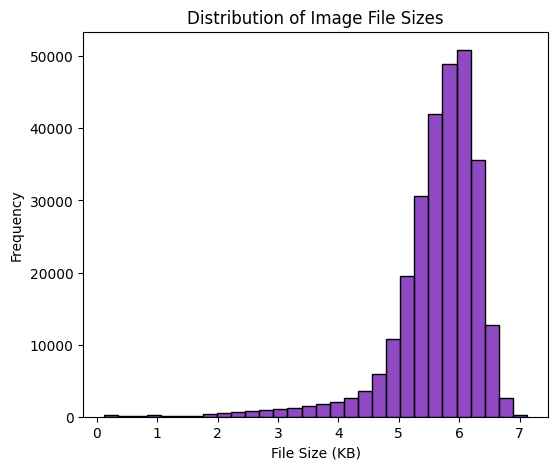

In [ ]:

plt.figure(figsize=(6, 5))
sns.histplot(df["file_size_bytes"] / 1024, bins=30, color="#6a0dad")  # Convert bytes to KB
plt.xlabel("File Size (KB)")
plt.ylabel("Frequency")
plt.title("Distribution of Image File Sizes")
plt.show()

## 2.2. Visualizing IDC Class Samples

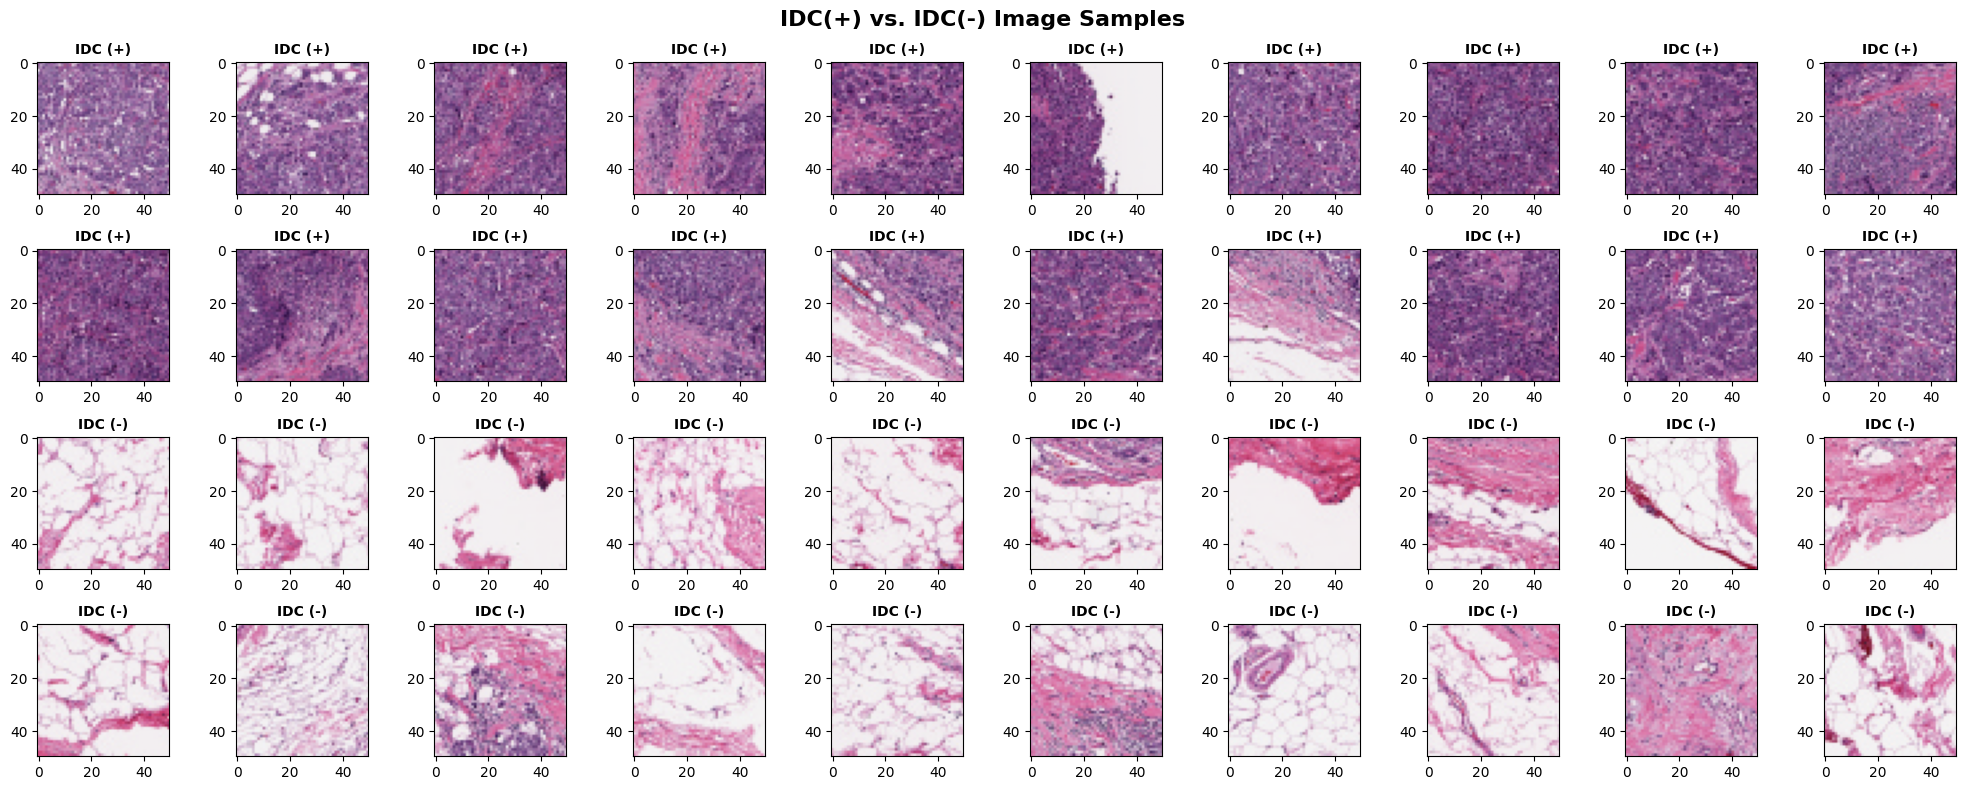

In [ ]:

# Number of images per category
num_per_category = 20  # 20 IDC(+) and 20 IDC(-)
columns = 10  # Number of columns per row
total_images = num_per_category * 2  # Total images (IDC(+) and IDC(-))

# Filter IDC(+) and IDC(-) images
idc_positive = df[df["class_label"] == 1]["file_path"].tolist()[:num_per_category]
idc_negative = df[df["class_label"] == 0]["file_path"].tolist()[:num_per_category]

# Ensure we have enough images
num_pos = len(idc_positive)
num_neg = len(idc_negative)
num_per_category = min(num_pos, num_neg)  # Adjust if either category has fewer images

# Combine images into a single list
image_files = idc_positive + idc_negative
labels = ["IDC (+)"] * num_per_category + ["IDC (-)"] * num_per_category

# Calculate rows required (Ceiling division)
rows = (total_images + columns - 1) // columns

# Create subplots
fig, ax = plt.subplots(rows, columns, figsize=(20, rows * 2))
ax = ax.flatten()  # Flatten for easy indexing

# Add title headers for IDC(+) and IDC(-)
fig.suptitle("IDC(+) vs. IDC(-) Image Samples", fontsize=16, fontweight="bold")

# Loop through the images and display them
for i, (img_file, label) in enumerate(zip(image_files, labels)):
    image = mpimg.imread(img_file)
    ax[i].imshow(image)
    # ax[i].axis('off')  # Hide axes
    ax[i].set_title(label, fontsize=10, fontweight="bold")

# Hide any unused subplots
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()


## 2.3. IDC Class Distribution Analysis

<ipython-input-18-d25c216957cc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df, palette=["#4169E1", "#DC143C"])


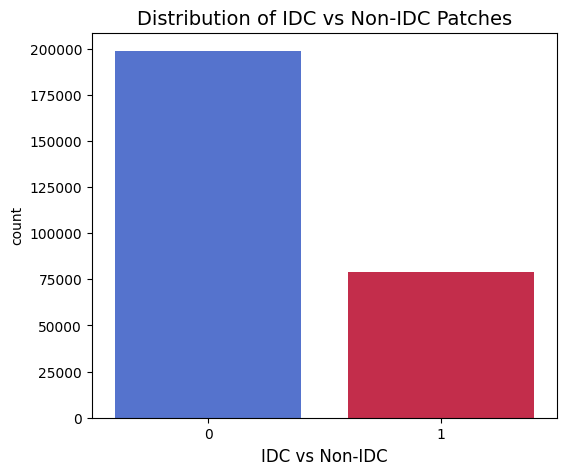

In [ ]:
# Create a separate figure for the third graph
plt.figure(figsize=(6, 5))

# 3. Count plot of IDC presence
sns.countplot(x="class_label", data=df, palette=["#4169E1", "#DC143C"])
plt.xlabel("IDC vs Non-IDC", fontsize=12)
plt.title("Distribution of IDC vs Non-IDC Patches", fontsize=14)

# Show the second figure
plt.show()

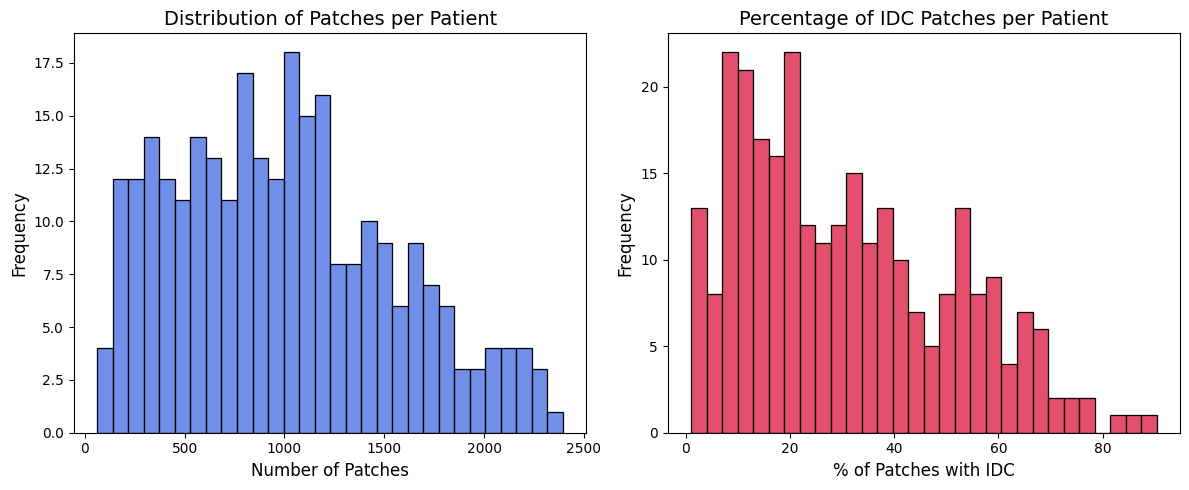

In [ ]:

# Calculate the percentage of IDC patches per patient
cancer_perc = df.groupby("patient_id")["class_label"].value_counts(normalize=True).unstack().fillna(0) * 100

# Create subplots for the first two histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogram of patches per patient
sns.histplot(df.groupby("patient_id").size(), ax=ax[0], color="#4169E1", bins=30)
ax[0].set_xlabel("Number of Patches", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)
ax[0].set_title("Distribution of Patches per Patient", fontsize=14)

# 2. Histogram of IDC percentage per patient
sns.histplot(cancer_perc[1], ax=ax[1], color="#DC143C", bins=30)
ax[1].set_xlabel("% of Patches with IDC", fontsize=12)
ax[1].set_ylabel("Frequency", fontsize=12)
ax[1].set_title("Percentage of IDC Patches per Patient", fontsize=14)

# Adjust layout and show the first figure
plt.tight_layout()
plt.show()

## 2.4. IDC Class Distribution Over Patients
A stacked bar plot to compare the number of IDC vs. non-IDC patches for different patients.
Since there are too many patients, only the top 25 with the most patches are displayed

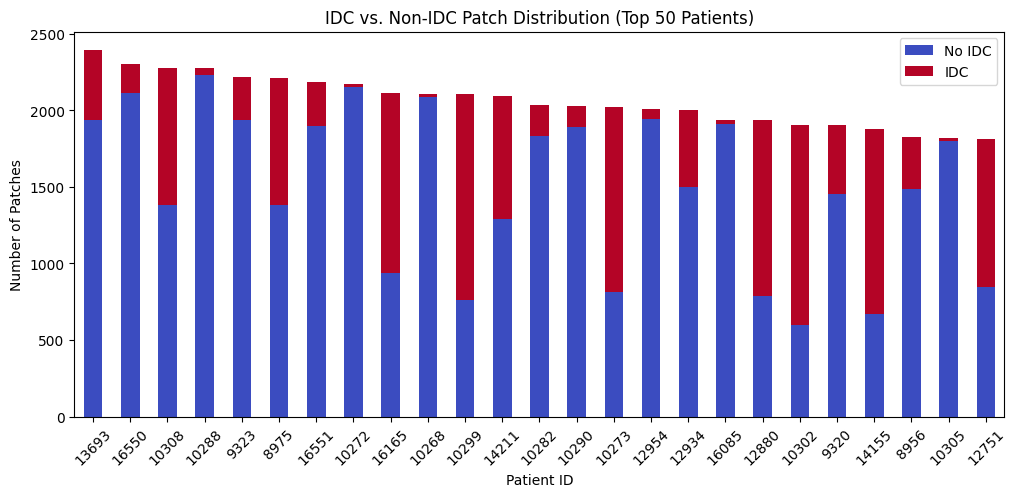

In [ ]:
# Group by patient_id and count the number of IDC and Non-IDC patches
cancer_counts = df.groupby("patient_id")["class_label"].value_counts().unstack().fillna(0)
# Get the top 25 patients with the most patches
top_patients = df["patient_id"].value_counts().nlargest(25).index

cancer_counts.loc[top_patients].plot(kind="bar", stacked=True, figsize=(12, 5), colormap="coolwarm")
plt.xlabel("Patient ID")
plt.ylabel("Number of Patches")
plt.title("IDC vs. Non-IDC Patch Distribution (Top 50 Patients)")
plt.xticks(rotation=45)  # Rotate slightly for better readability
plt.legend(["No IDC", "IDC"])
plt.show()


## 2.5. Group Patients by Patch Count Ranges
Instead of plotting every patient, we group them into bins based on their total patch counts. This simplifies visualization while keeping insights.

<ipython-input-21-482cfc6a2d5f>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df.groupby("patch_range")["class_label"].value_counts().unstack().fillna(0)


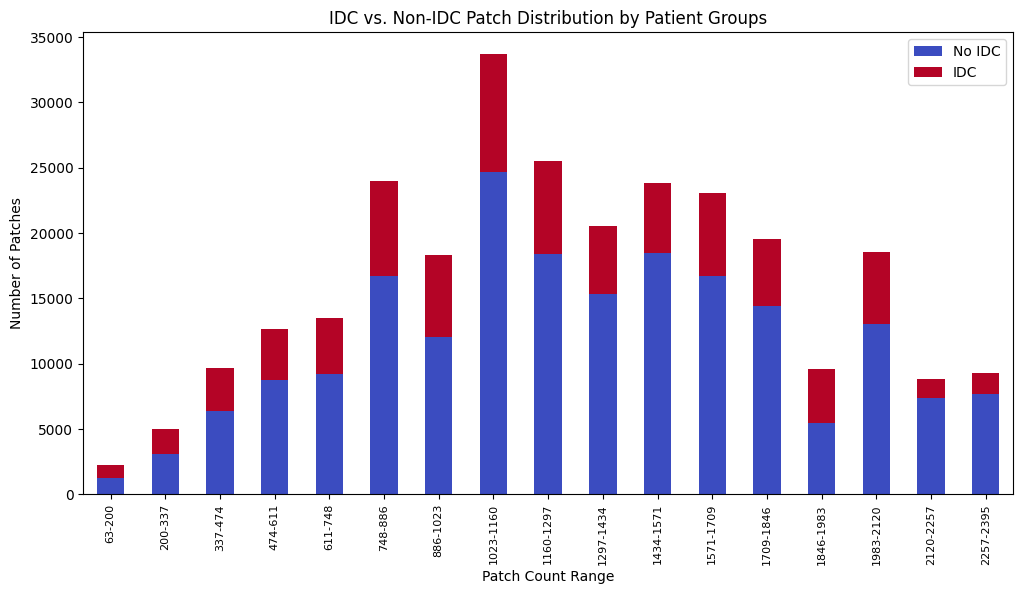

In [ ]:
# Calculate the number of patches per patient
df["patch_count"] = df.groupby("patient_id")["patient_id"].transform("count")

# Calculate bins dynamically based on patient patch counts
num_bins = 17
bin_edges = np.linspace(df["patch_count"].min(), df["patch_count"].max(), num_bins + 1)

# Create bin labels dynamically
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

# Assign patients to bins
df["patch_range"] = pd.cut(df["patch_count"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Aggregate IDC vs. Non-IDC patches within each range
grouped_counts = df.groupby("patch_range")["class_label"].value_counts().unstack().fillna(0)

# Plot the aggregated data
grouped_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Patch Count Range")
plt.ylabel("Number of Patches")
plt.title("IDC vs. Non-IDC Patch Distribution by Patient Groups")
plt.xticks(rotation=90, fontsize=8)  # Rotate labels for better visibility
plt.legend(["No IDC", "IDC"])
plt.show()


## 2.3. Spatial Distribution of IDC Patches
A scatter plot to visualize where IDC-positive patches (class_label == 1) appear spatially.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


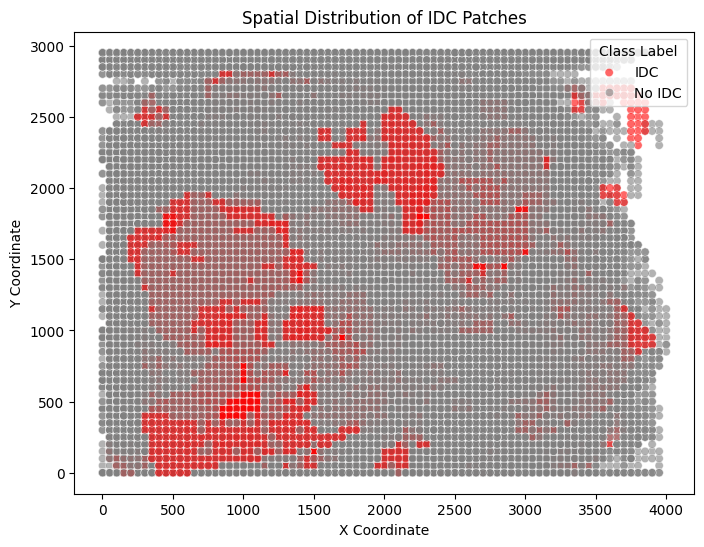

In [ ]:
# check distribution of patches, why is red not IDC....
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x_coordinate", y="y_coordinate", hue="class_label", alpha=0.6, palette={0: "gray", 1: "red"})
plt.title("Spatial Distribution of IDC Patches")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="Class Label", labels=["IDC", "No IDC"])
plt.show()


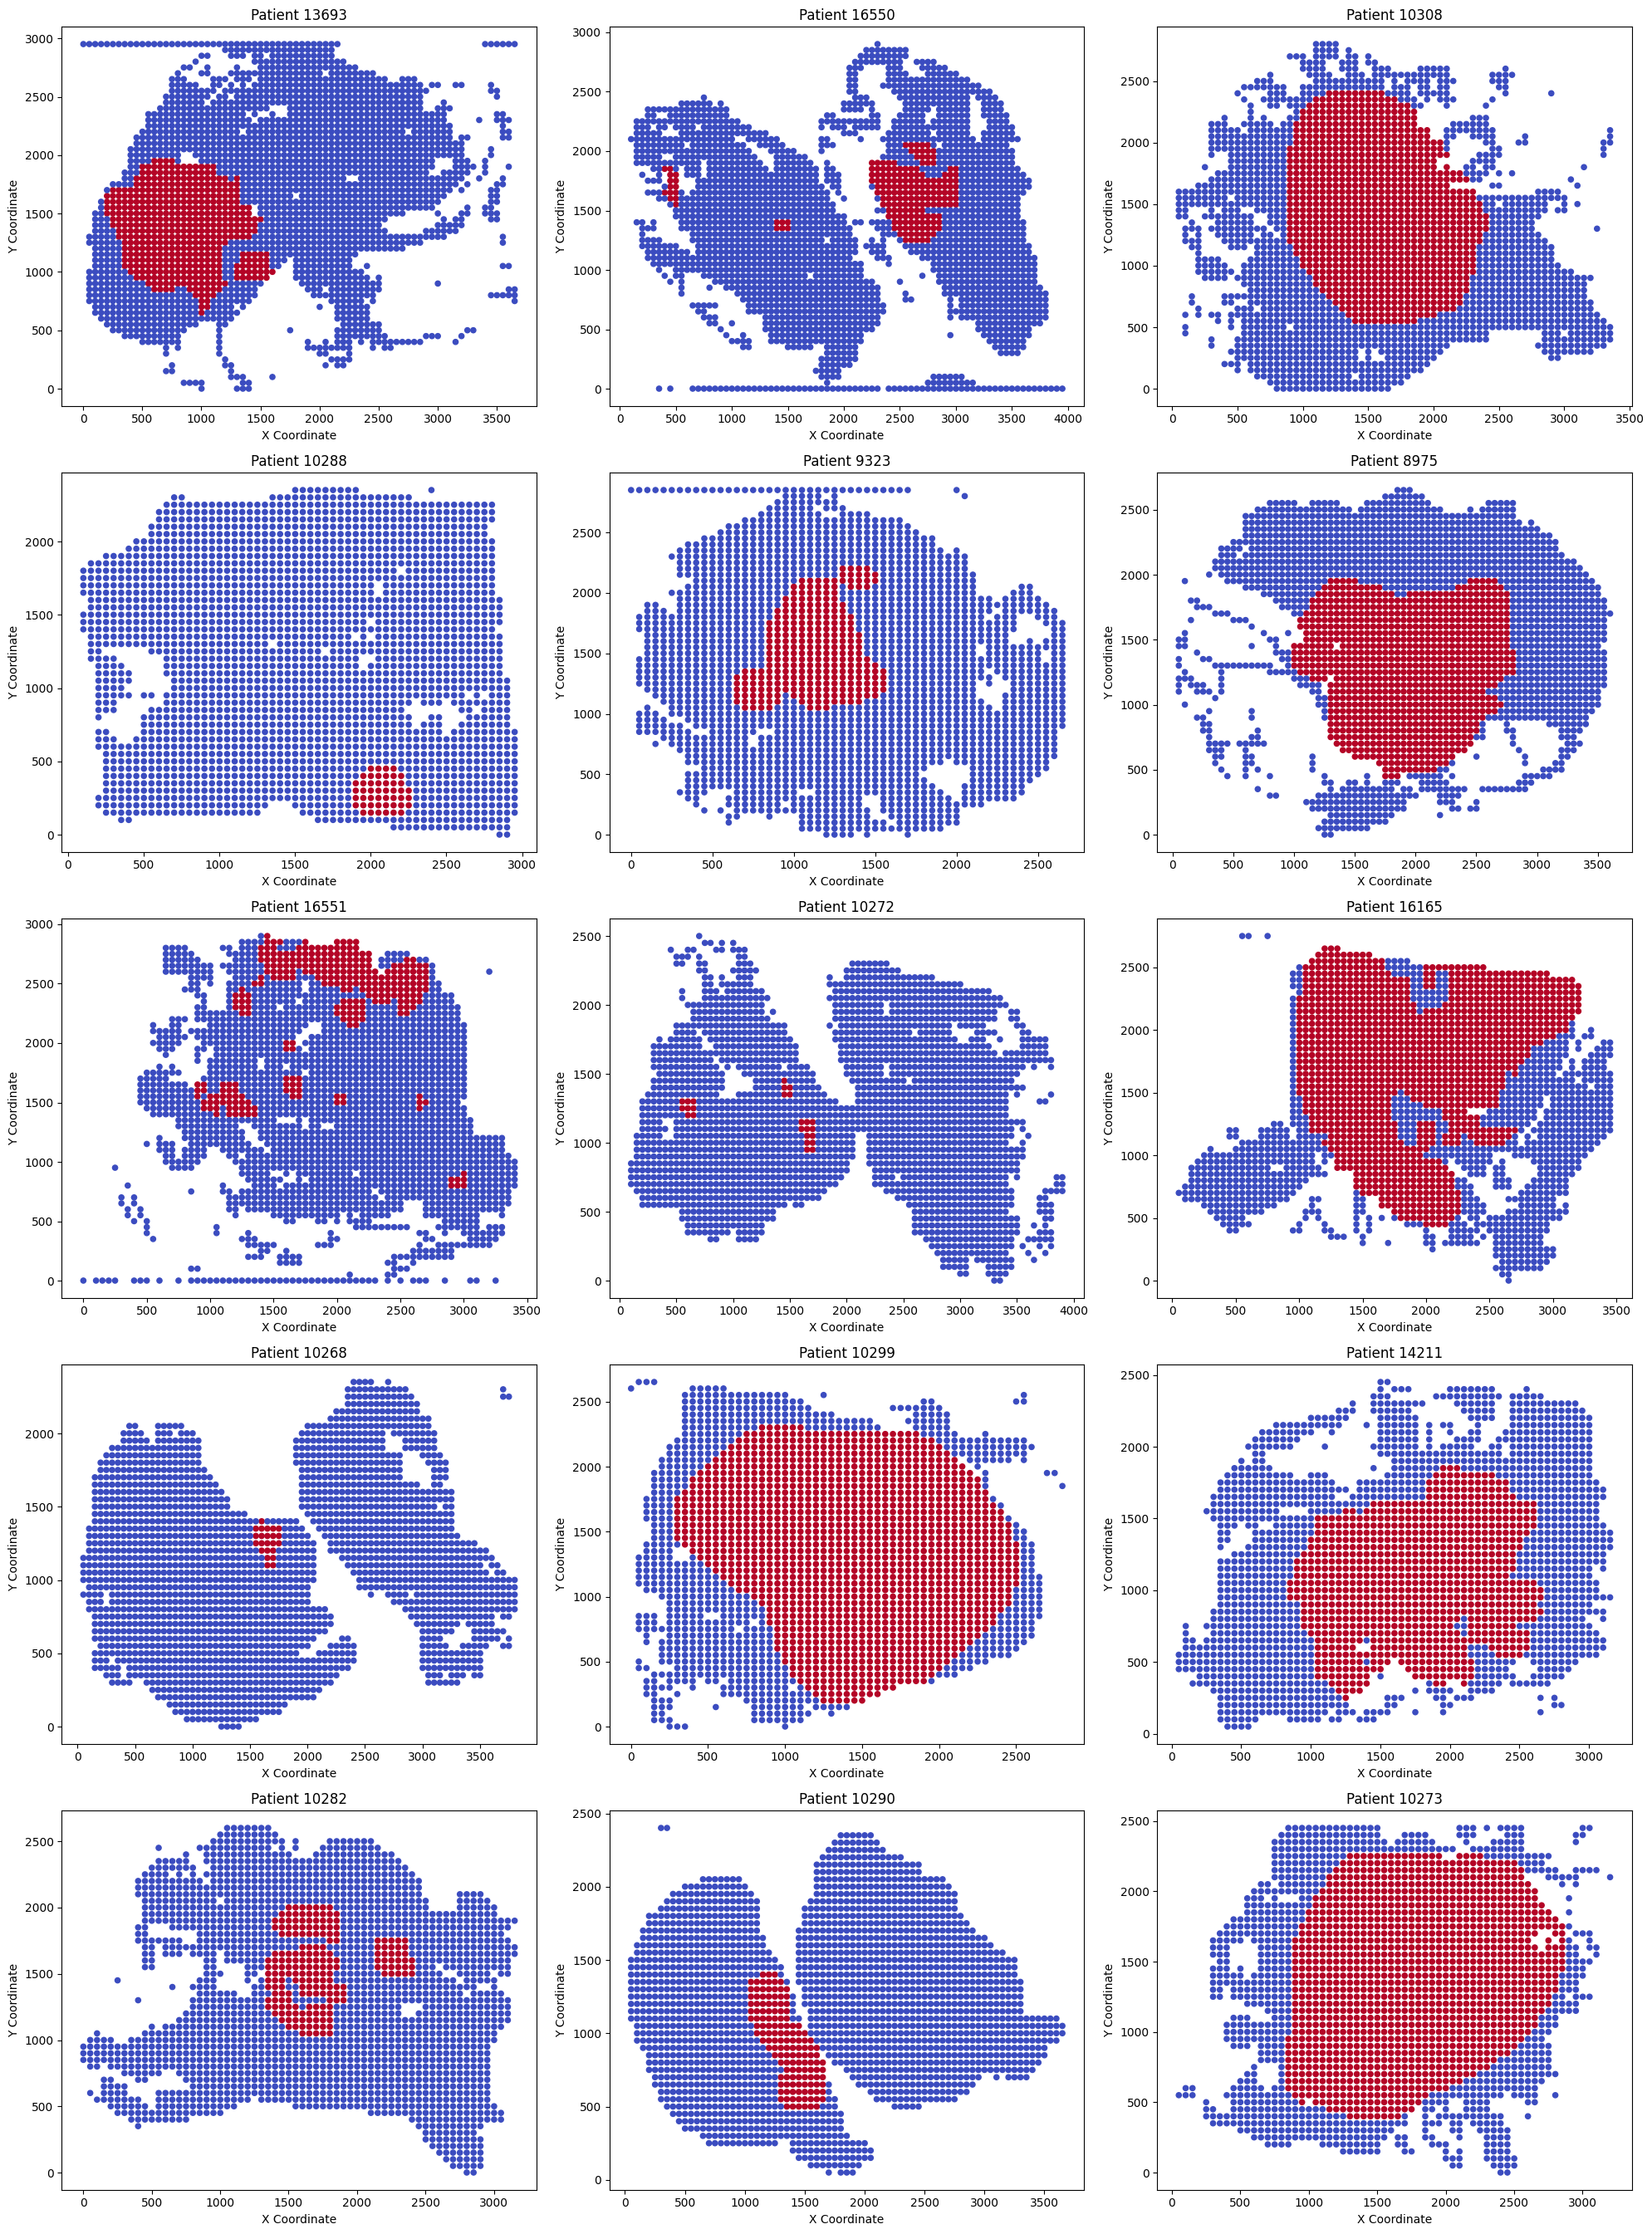

In [ ]:

# Function to get the dataframe for a given patient_id
def get_patient_dataframe(patient_id):
    return df[df["patient_id"] == patient_id]

# Define number of rows and columns for the subplot grid
num_rows = 5
num_cols = 3

# Create a figure with subplots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 27))

# Get unique patient_ids
top_patients = df["patient_id"].value_counts().nlargest(15).index
patient_ids = top_patients

# Loop through the grid and plot scatter plots for each patient
for n in range(num_rows):
    for m in range(num_cols):
        # Ensure we are not exceeding the number of available patients
        if m + num_cols * n < len(patient_ids):
            patient_id = patient_ids[m + num_cols * n]
            example_df = get_patient_dataframe(patient_id)

            # Plot the scatter plot for the given patient
            ax[n, m].scatter(example_df.x_coordinate.values, example_df.y_coordinate.values,
                             c=example_df.class_label.values, cmap="coolwarm", s=20)
            ax[n, m].set_title(f"Patient {patient_id}")
            ax[n, m].set_xlabel("X Coordinate")
            ax[n, m].set_ylabel("Y Coordinate")
        else:
            # Hide empty subplots if patient data is not available
            ax[n, m].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# 3.1. Patch-based Approch

In [8]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import random


In [9]:
# Droping images that are not 50x50 since there are only 7 patches that are positive and 1311 negetive(which we have plenty of) because they are edges .. that have small to none features
# Ensure only images of size 50x50 are kept
def filter_images(df):
    valid_images = []
    invalid_images = []
    for file_path in df["file_path"]:
        image = tf.io.read_file(file_path)
        image = tf.image.decode_png(image, channels=3)
        shape = tf.shape(image)
        if shape[0] == 50 and shape[1] == 50:
            valid_images.append(file_path)
        else:
            invalid_images.append(file_path)
    return df[df["file_path"].isin(valid_images)], df[df["file_path"].isin(invalid_images)]

# Filter dataset
df, invalid_df = filter_images(df)

df.head()

patient_id  x_coordinate  y_coordinate  \
0        8984          1851          1351   
1        8984          2001          1501   
2        8984          2351          1101   
3        8984          2001          1351   
4        8984          1901          1551   

                                           file_path  class_label  \
0  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
1  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
2  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
3  /content/sample_data/IDC_regular_ps50_idx5/898...            1   
4  /content/sample_data/IDC_regular_ps50_idx5/898...            1   

   file_size_bytes           created_at     last_modified_at  
0             5948  2025-03-06 10:53:47  2025-03-06 10:53:47  
1             6452  2025-03-06 10:53:47  2025-03-06 10:53:47  
2             6246  2025-03-06 10:53:47  2025-03-06 10:53:47  
3             6108  2025-03-06 10:53:47  2025-03-06 10:53:47  
4             6274  2025-03-06 10:53:47  2025-03-06 10:53:47

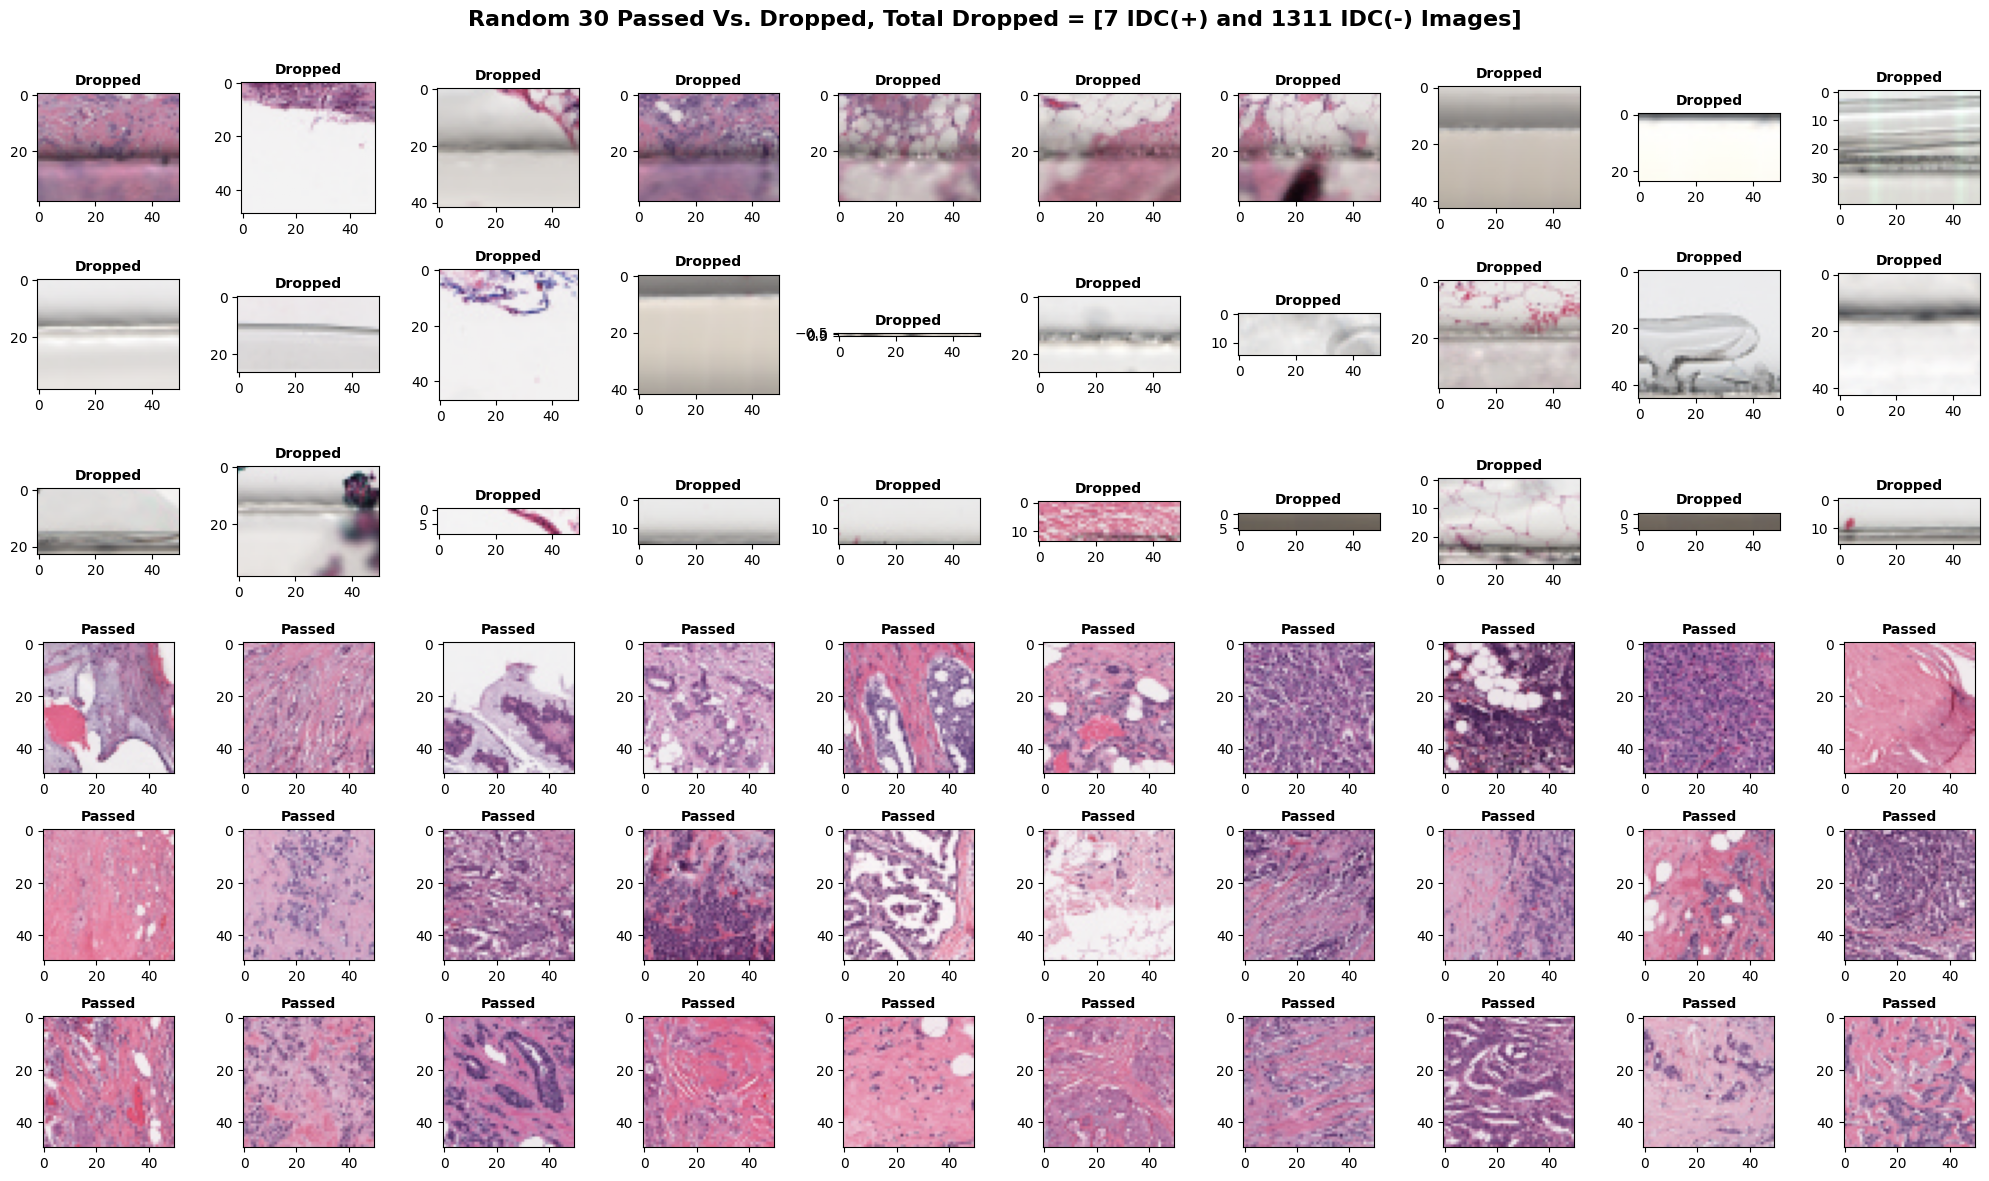

In [10]:

# Randomly select 7 dropped IDC(+) images and 23 dropped IDC(-) images
dropped_idc_positive = random.sample(invalid_df[invalid_df["class_label"] == 1]["file_path"].tolist(), 7)
dropped_idc_negative = random.sample(invalid_df[invalid_df["class_label"] == 0]["file_path"].tolist(), 23)

# Randomly select 30 passed images
passed_images = random.sample(df[df["class_label"] == 1]["file_path"].tolist(), 30)

# Combine the dropped images
dropped_images = dropped_idc_positive + dropped_idc_negative

# Create subplots with two sections (left for dropped, right for passed)
fig, ax = plt.subplots(6, 10, figsize=(20, 12))
ax = ax.flatten()

# Display dropped images on the left side
for i, img_file in enumerate(dropped_images):
    image = mpimg.imread(img_file)
    ax[i].imshow(image)
    # ax[i].axis('off')  # Hide axes
    ax[i].set_title("Dropped", fontsize=10, fontweight="bold")

# Display passed images on the right side
for i, img_file in enumerate(passed_images):
    image = mpimg.imread(img_file)
    ax[i + 30].imshow(image)
    # ax[i + 30].axis('off')  # Hide axes
    ax[i + 30].set_title("Passed", fontsize=10, fontweight="bold")

# Set the title for the entire plot
plt.suptitle(f"Random 30 Passed Vs. Dropped, Total Dropped = [7 IDC(+) and 1311 IDC(-) Images]", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust to make room for the suptitle
plt.show()


# Train - Validation - Test Split

In [11]:

# Split dataset into Train (80%), Validation (10%), Test (10%) using stratification
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_label'], random_state=42)


<ipython-input-12-05a98f2d9533>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])
<ipython-input-12-05a98f2d9533>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])
<ipython-input-12-05a98f2d9533>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])


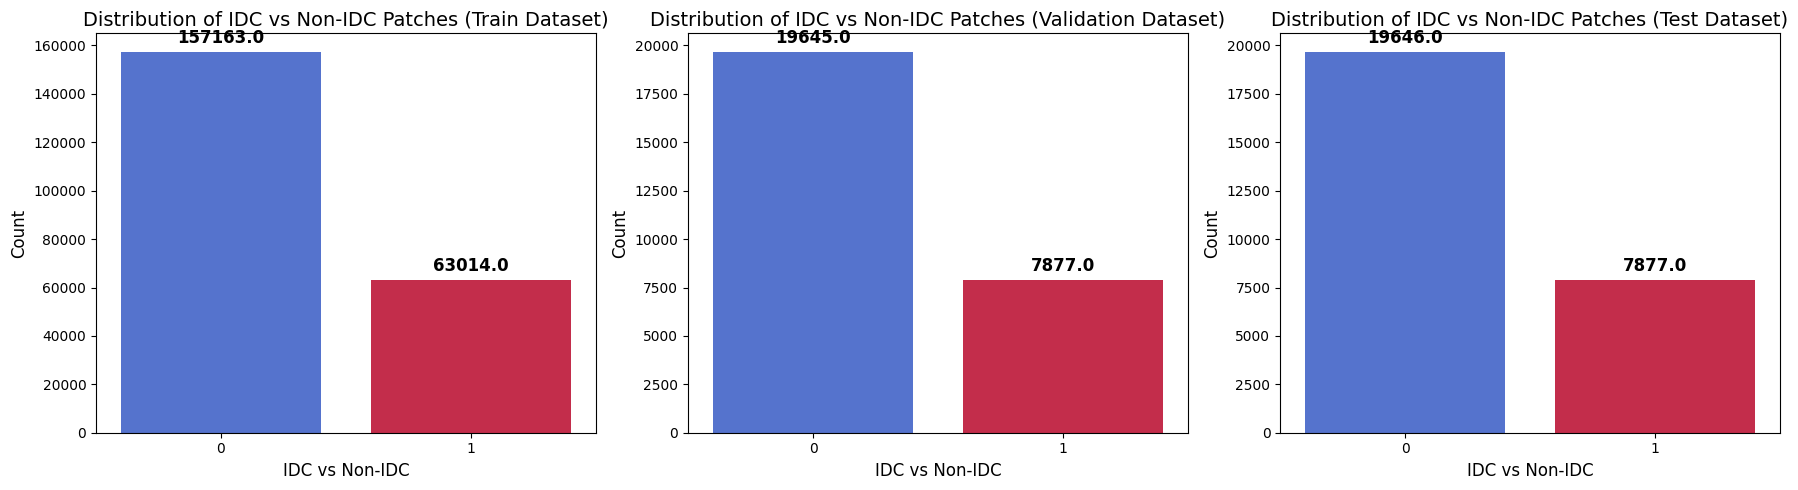

In [12]:

# Create subplots for the three datasets
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Define datasets and titles
datasets = [train_df, val_df, test_df]
titles = ["Train Dataset", "Validation Dataset", "Test Dataset"]

# Iterate through datasets and plot count plots
for i, df_split in enumerate(datasets):
    # Create the countplot
    sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])

    # Add labels for each bar
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, fontweight='bold', color='black', xytext=(0, 10), textcoords='offset points')

    ax[i].set_xlabel("IDC vs Non-IDC", fontsize=12)
    ax[i].set_ylabel("Count", fontsize=12)
    ax[i].set_title(f"Distribution of IDC vs Non-IDC Patches ({titles[i]})", fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Data Augmentation

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.image import flip_left_right, random_brightness, random_contrast, random_saturation, rot90
from sklearn.model_selection import train_test_split

# Load your dataset
path = "/content/sample_data/IDC_regular_ps50_idx5"
df = load_image_data_to_dataframe(path)

# Split dataset into Train (80%), Validation (10%), Test (10%) using stratification
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_label'], random_state=42)

# Select only Class 1 images
class_1_df = train_df[train_df['class_label'] == 1]

# Compute number of new images needed (50% increase)
num_augmented_images = len(class_1_df) // 2

# Select random images from class 1 to augment
selected_images = class_1_df.sample(n=num_augmented_images, random_state=42)

# Define augmentation function
def augment_image(image):
    image = flip_left_right(image)  # Horizontal flip
    image = rot90(image, k=random.choice([1, 2, 3]))  # Random 90-degree rotation
    image = random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    image = random_saturation(image, lower=0.8, upper=1.2)  # Adjust saturation
    return image

# Function to load and preprocess images
def load_and_augment_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [50, 50])  # Resize to standard dimensions
    image = augment_image(image)  # Apply augmentation
    return image

# Apply augmentation
augmented_images = [load_and_augment_image(f) for f in selected_images['file_path']]

# Convert augmented images to numpy arrays
augmented_images = [img.numpy().astype(np.uint8) for img in augmented_images]

# Visualize some sample original vs. augmented images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(5):
    original_img = tf.image.decode_png(tf.io.read_file(selected_images.iloc[i]['file_path']), channels=3)
    original_img = tf.image.resize(original_img, [50, 50]).numpy().astype(np.uint8)

    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(augmented_images[i])
    axes[1, i].axis('off')
    axes[1, i].set_title("Augmented")

plt.show()

# Add augmented images to the training dataset
augmented_df = pd.DataFrame({
    "patient_id": selected_images["patient_id"].values,
    "x_coordinate": selected_images["x_coordinate"].values,
    "y_coordinate": selected_images["y_coordinate"].values,
    "file_path": selected_images["file_path"].values,  # Placeholder
    "class_label": [1] * num_augmented_images,
    "file_size_bytes": selected_images["file_size_bytes"].values,
    "created_at": selected_images["created_at"].values,
    "last_modified_at": selected_images["last_modified_at"].values
})

# Append to train_df
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Convert to tf.data.Dataset
def parse_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [50, 50])
    image = image / 255.0  # Normalize
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df["file_path"], train_df["class_label"]))
train_ds = train_ds.map(parse_image).batch(32).shuffle(1000)

# Check dataset size
print(f"New training dataset size: {len(train_df)}")


In [ ]:

# # Count IDC(-) and IDC(+) in training data
# class_counts = train_df["class_label"].value_counts()
# class_0_count = class_counts[0]  # Non-IDC
# class_1_count = class_counts[1]  # IDC

# # If class 1 is smaller, duplicate and augment until balanced
# if class_1_count < class_0_count:
#     class_1_df = train_df[train_df["class_label"] == 1]
#     num_augments_needed = int(class_1_count / 2)

#     # Duplicate and augment class 1 images
#     augmented_class_1_df = class_1_df.sample(num_augments_needed, replace=True, random_state=42)
#     train_df = pd.concat([train_df, augmented_class_1_df], ignore_index=True)
#     augmented_class_1_file_paths = set(augmented_class_1_df["file_path"].tolist())

# # Define image augmentation for IDC(+) class
# def augment_image(image):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     return image


In [13]:

# def should_augment(file_path):
#     """Check if the file_path is in augmented_class_1_file_paths (runs in Python mode)."""
#     # file_path_str = tf.compat.as_str_any(file_path.numpy())  # Convert tensor to string safely
#     # return file_path_str in augmented_class_1_file_paths
#     file_path_str = tf.compat.as_str_any(file_path.numpy())  # Convert tensor to string safely
#     augmented_file_paths = []
#     if file_path_str in augmented_class_1_file_paths:
#       if file_path_str not in augmented_file_paths:
#         augmented_file_paths.append(file_path_str)
#         return True
#     return False


def load_and_preprocess_image(file_path, label):
    """Load, preprocess, and conditionally augment an image."""

    # Read and decode image
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to model input size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    # def augment_condition():
    #     return tf.py_function(func=should_augment, inp=[file_path], Tout=tf.bool)

    # # Apply augmentation only if needed
    # if_augmented = tf.logical_and(tf.equal(label, 1), augment_condition())
    # image = tf.cond(if_augmented, lambda: augment_image(image), lambda: image)

    return image, label


In [14]:
def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['file_path'].values, dataframe['class_label'].values))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

In [15]:

# # For TPU strategy:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)

# with strategy.scope():
#     train_dataset = create_dataset(train_df)
#     val_dataset = create_dataset(val_df)
#     test_dataset = create_dataset(test_df)

# For GPU strategy:
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)


<ipython-input-11-43c29d6935a6>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])
<ipython-input-11-43c29d6935a6>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])
<ipython-input-11-43c29d6935a6>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])


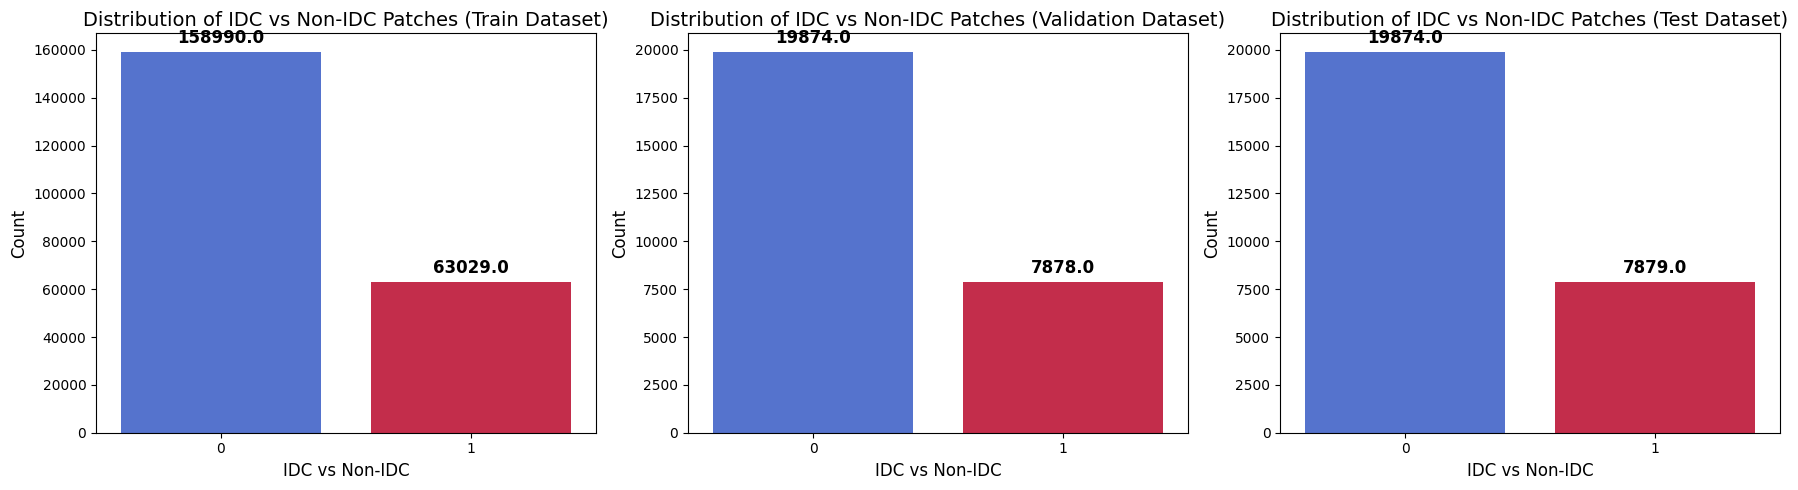

In [ ]:

def extract_labels(dataset):
    """Extract labels from a TensorFlow dataset and return a NumPy array."""
    labels = []

    for _, label in dataset:
        label = label.numpy()  # Convert Tensor to NumPy
        if isinstance(label, np.ndarray) and label.ndim > 0:
            labels.extend(label.flatten().tolist())  # Flatten nested structures
        else:
            labels.append(int(label))  # Ensure scalar values

    return np.array(labels, dtype=np.int32)  # Ensure uniform dtype

# Extract labels
train_labels = extract_labels(train_dataset)
val_labels = extract_labels(val_dataset)
test_labels = extract_labels(test_dataset)


# Create DataFrames for the datasets and corresponding class labels
train_df = pd.DataFrame({"class_label": train_labels})
val_df = pd.DataFrame({"class_label": val_labels})
test_df = pd.DataFrame({"class_label": test_labels})

# Create subplots for the three datasets
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Define datasets and titles
datasets = [train_df, val_df, test_df]
titles = ["Train Dataset", "Validation Dataset", "Test Dataset"]

# Iterate through datasets and plot count plots
for i, df_split in enumerate(datasets):
    # Create the countplot
    sns.countplot(x="class_label", data=df_split, palette=["#4169E1", "#DC143C"], ax=ax[i])

    # Add labels for each bar
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, fontweight='bold', color='black', xytext=(0, 10), textcoords='offset points')

    ax[i].set_xlabel("IDC vs Non-IDC", fontsize=12)
    ax[i].set_ylabel("Count", fontsize=12)
    ax[i].set_title(f"Distribution of IDC vs Non-IDC Patches ({titles[i]})", fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Comparative analysis between selected pretrained models

### Model Creation

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50, DenseNet121, InceptionV3, Xception,
    InceptionResNetV2, EfficientNetB0, EfficientNetB1, EfficientNetB2,
    EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

EPOCHS = 2  # Or your desired number of epochs

# Function to create the model with the base model passed in
def create_model(base_model):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [6]:

# Function to plot training and validation accuracy and loss
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()
    ax[0].set_ylim([0, 1])  # Accuracy values should be between 0 and 1

    # Plot loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


def evaluate_model(model, dataset):
    # Define the built-in metrics
    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()
    f1_metric = tf.keras.metrics.AUC()  # AUC can approximate F1 score in some cases, but it's more general

    # Iterate through the dataset
    for images, labels in dataset:
        # Make predictions on the batch
        preds = model.predict_on_batch(images)

        # Update the metrics
        accuracy_metric.update_state(labels, preds)
        precision_metric.update_state(labels, preds)
        recall_metric.update_state(labels, preds)
        f1_metric.update_state(labels, preds)

    # Get final results
    accuracy = accuracy_metric.result().numpy()
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    f1 = f1_metric.result().numpy()

    return accuracy, precision, recall, f1



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 812s 110ms/step - accuracy: 0.8679 - loss: 0.3114 - val_accuracy: 0.8761 - val_loss: 0.5181
Epoch 2/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 751s 108ms/step - accuracy: 0.8921 - loss: 0.2592 - val_accuracy: 0.8849 - val_loss: 0.3434


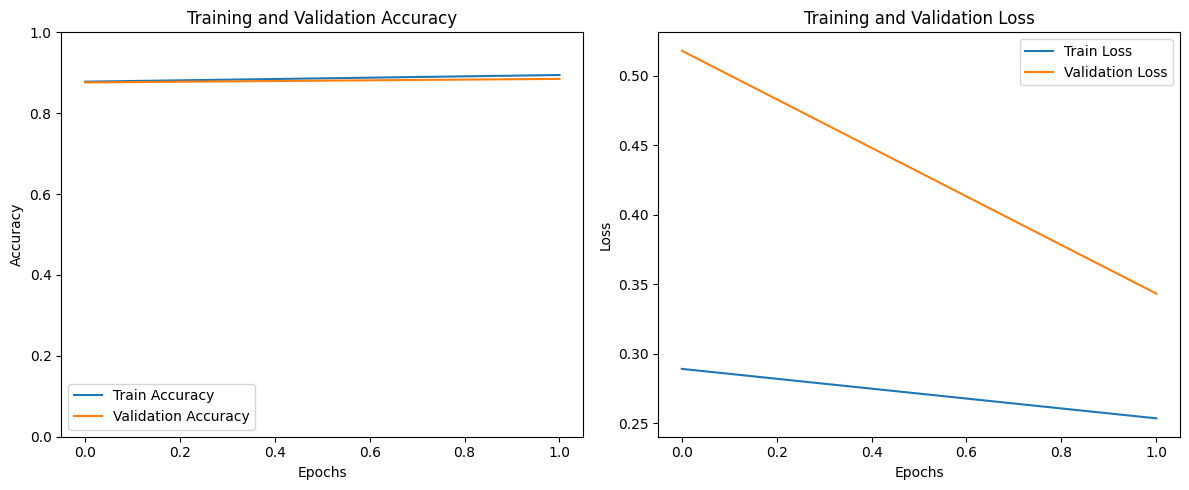

MobileNetV2 - Accuracy: 0.888120174407959, Precision: 0.8591634035110474, Recall: 0.7247112393379211, F1 Score: 0.9373142719268799


In [ ]:
# - if TPU strategy (nest under the ff)
# with strategy.scope():


# MobileNetV2
mobilenetv2_model = create_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
mobilenetv2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_mobilenetv2 = mobilenetv2_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_mobilenetv2)

# Evaluate the model on test dataset
metrics_mobilenetv2 = evaluate_model(mobilenetv2_model, test_dataset)
print(f"MobileNetV2 - Accuracy: {metrics_mobilenetv2[0]}, Precision: {metrics_mobilenetv2[1]}, Recall: {metrics_mobilenetv2[2]}, F1 Score: {metrics_mobilenetv2[3]}")



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 2312s 309ms/step - accuracy: 0.8607 - loss: 0.3311 - val_accuracy: 0.8578 - val_loss: 0.4870
Epoch 2/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 2008s 289ms/step - accuracy: 0.8854 - loss: 0.2743 - val_accuracy: 0.8729 - val_loss: 0.3075


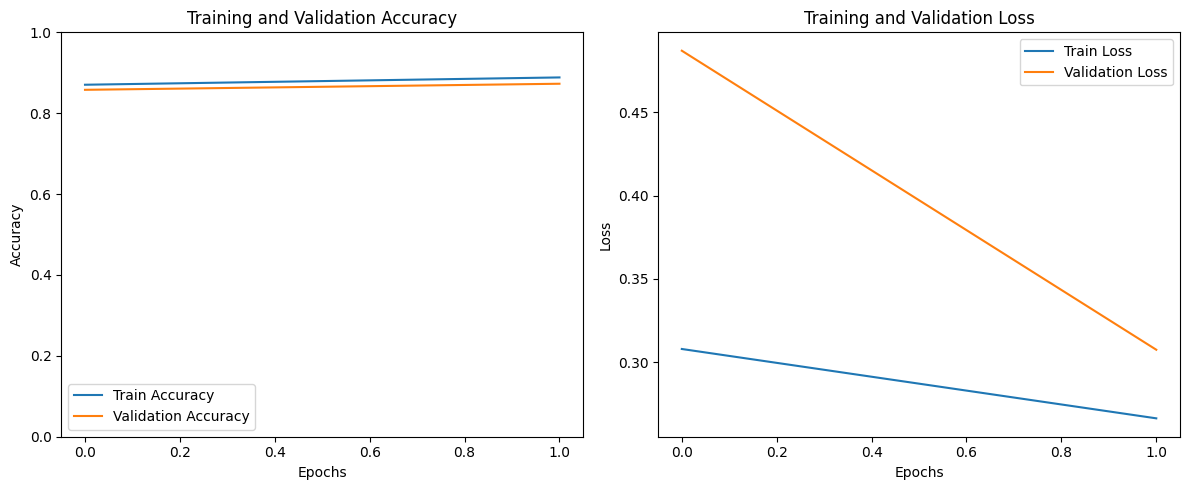

Densenet121 - Accuracy: 0.8734551072120667, Precision: 0.7977635264396667, Recall: 0.7424800395965576, F1 Score: 0.9250832200050354


In [ ]:

# DenseNet121
densenet121_model = create_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
densenet121_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_densenet121 = densenet121_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_densenet121)

# Evaluate the model on test dataset
metrics_densenet121 = evaluate_model(densenet121_model, test_dataset)
print(f"Densenet121 - Accuracy: {metrics_densenet121[0]}, Precision: {metrics_densenet121[1]}, Recall: {metrics_densenet121[2]}, F1 Score: {metrics_densenet121[3]}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 2193s 307ms/step - accuracy: 0.8518 - loss: 0.3558 - val_accuracy: 0.8119 - val_loss: 0.5305
Epoch 2/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 2092s 301ms/step - accuracy: 0.8787 - loss: 0.2891 - val_accuracy: 0.8629 - val_loss: 0.3321


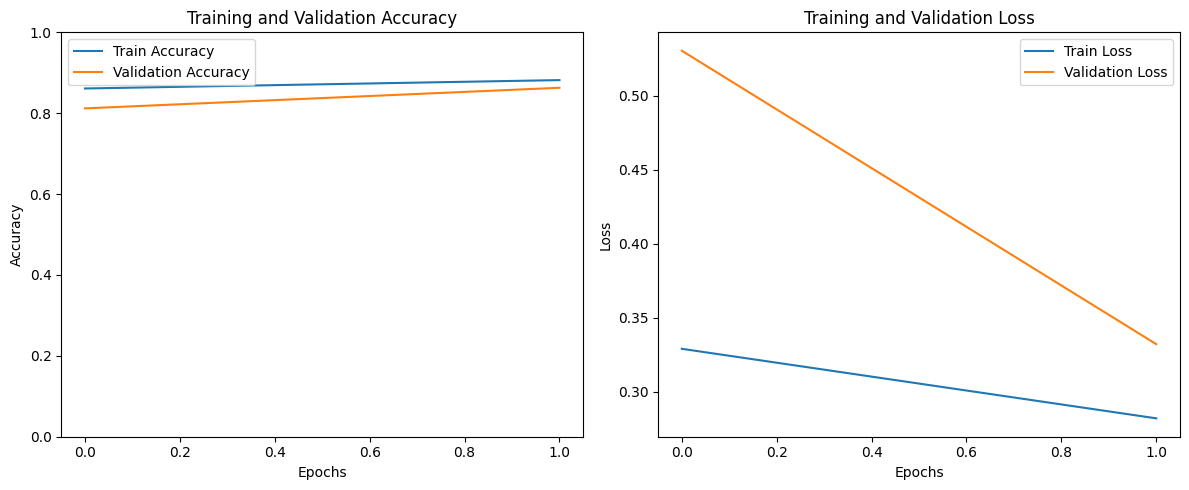

ResNet50 - Accuracy: 0.8648074269294739, Precision: 0.7380320429801941, Recall: 0.8120319843292236, F1 Score: 0.9266999959945679


In [ ]:

# ResNet50
resnet50_model = create_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet50 = resnet50_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


# Plot Accuracy
plot_training_history(history_resnet50)

metrics_resnet50 = evaluate_model(resnet50_model, test_dataset)
print(f"ResNet50 - Accuracy: {metrics_resnet50[0]}, Precision: {metrics_resnet50[1]}, Recall: {metrics_resnet50[2]}, F1 Score: {metrics_resnet50[3]}")

In [ ]:

# InceptionV3
inceptionv3_model = create_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inceptionv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_inceptionv3 = inceptionv3_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_inceptionv3)

metrics_inceptionv3 = evaluate_model(inceptionv3_model, test_dataset)
print(f"Inceptionv3 - Accuracy: {metrics_inceptionv3[0]}, Precision: {metrics_inceptionv3[1]}, Recall: {metrics_inceptionv3[2]}, F1 Score: {metrics_inceptionv3[3]}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/2
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 1763s 243ms/step - accuracy: 0.8547 - loss: 0.3442 - val_accuracy: 0.8705 - val_loss: 0.3140
Epoch 2/2
1410/6939 ━━━━━━━━━━━━━━━━━━━━ 20:52 226ms/step - accuracy: 0.8834 - loss: 0.2833

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/2
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 4318s 603ms/step - accuracy: 0.8659 - loss: 0.3229 - val_accuracy: 0.8750 - val_loss: 0.3231
Epoch 2/2
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 4010s 583ms/step - accuracy: 0.8847 - loss: 0.2750 - val_accuracy: 0.8897 - val_loss: 0.2594


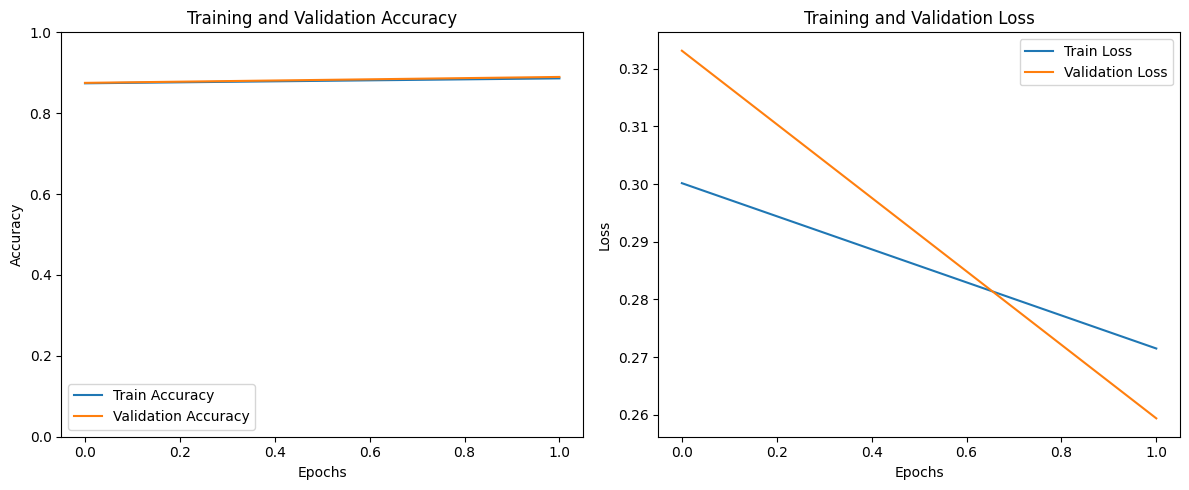

Inceptionv3 - Accuracy: 0.8923808932304382, Precision: 0.8534445762634277, Recall: 0.7533324956893921, F1 Score: 0.9511815905570984


In [14]:

# InceptionResNetV2
inceptionresnetv2_model = create_model(InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
inceptionresnetv2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_inceptionresnetv2 = inceptionresnetv2_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_inceptionresnetv2)

metrics_inceptionresnetv2 = evaluate_model(inceptionresnetv2_model, test_dataset)
print(f"InceptionResNetV2 - Accuracy: {metrics_inceptionresnetv2[0]}, Precision: {metrics_inceptionresnetv2[1]}, Recall: {metrics_inceptionresnetv2[2]}, F1 Score: {metrics_inceptionresnetv2[3]}")


In [ ]:

# Xception
xception_model = create_model(Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_xception = xception_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_xception)

metrics_xception = evaluate_model(xception_model, test_dataset)
print(f"Inceptionv3 - Accuracy: {metrics_xception[0]}, Precision: {metrics_xception[1]}, Recall: {metrics_xception[2]}, F1 Score: {metrics_xception[3]}")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 3844s 550ms/step - accuracy: 0.8753 - loss: 0.2996 - val_accuracy: 0.8806 - val_loss: 0.2853
Epoch 2/2
2823/6881 ━━━━━━━━━━━━━━━━━━━━ 35:37 527ms/step - accuracy: 0.8988 - loss: 0.2430

In [ ]:

# EfficientNetB7
efficientnetb7_model = create_model(EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb7_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb7 = efficientnetb7_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Plot Accuracy
plot_training_history(history_efficientnetb7)

metrics_efficientnetb7 = evaluate_model(efficientnetb7_model, test_dataset)
print(f"Inceptionv3 - Accuracy: {metrics_efficientnetb7[0]}, Precision: {metrics_efficientnetb7[1]}, Recall: {metrics_efficientnetb7[2]}, F1 Score: {metrics_efficientnetb7[3]}")

Epoch 1/2
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 6859s 959ms/step - accuracy: 0.8739 - loss: 0.2985 - val_accuracy: 0.2862 - val_loss: 35.3206
Epoch 2/2
1858/6881 ━━━━━━━━━━━━━━━━━━━━ 1:16:13 910ms/step - accuracy: 0.8978 - loss: 0.2429

In [ ]:
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6
)


# EfficientNetB0
efficientnetb0_model = create_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb0_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb0 = efficientnetb0_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB1
efficientnetb1_model = create_model(EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb1 = efficientnetb1_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB2
efficientnetb2_model = create_model(EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb2 = efficientnetb2_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB3
efficientnetb3_model = create_model(EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb3 = efficientnetb3_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB4
efficientnetb4_model = create_model(EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb4_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb4 = efficientnetb4_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB5
efficientnetb5_model = create_model(EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb5_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb5 = efficientnetb5_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# EfficientNetB6
efficientnetb6_model = create_model(EfficientNetB6(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnetb6_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_efficientnetb6 = efficientnetb6_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


In [ ]:

# Grad-CAM Implementation
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(np.array([img_array]))
        loss = preds[0][0]  # Grad-CAM for binary classification

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()

def display_grad_cam(img_array, heatmap):
    img = cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[0], IMG_SIZE[1]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img
    plt.imshow(superimposed_img / 255)
    plt.axis('off')
    plt.show()

# Test Grad-CAM
layer_name = 'conv5_block3_out'  # Adjust this based on the model architecture
test_image_index = 0
sample_image, _ = validation_generator[test_image_index]
heatmap = grad_cam(resnet_model, sample_image, layer_

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2

# # Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
# DATASET_PATH = '/content/sample_data/IDC_regular_ps50_idx5/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5





# Data Augmentation and Loading
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Split data into training and validation
)


df["file_path"] = df["file_path"].astype(str)
df["class_label"] = df["class_label"].astype(str)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='file_path',
    y_col='class_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    # shuffle=True
    subset='training',
)


validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='file_path',
    y_col='class_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    # shuffle=True
    subset='validation',
)




# Build Model Function
def create_model(base_model):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Models
resnet_model = create_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
densenet_model = create_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
vgg_model = create_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))

# Train Models
history_resnet = resnet_model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS)
history_densenet = densenet_model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS)
history_vgg = vgg_model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS)

# Evaluate Models
def evaluate_model(model, generator):
    generator.reset()
    predictions = model.predict(generator)
    predictions = np.round(predictions).astype(int).flatten()

    true_labels = generator.classes
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return accuracy, precision, recall, f1

metrics_resnet = evaluate_model(resnet_model, validation_generator)
metrics_densenet = evaluate_model(densenet_model, validation_generator)
metrics_vgg = evaluate_model(vgg_model, validation_generator)

# Display Metrics
metrics_df = pd.DataFrame({
    'Model': ['ResNet', 'DenseNet', 'VGG'],
    'Accuracy': [metrics_resnet[0], metrics_densenet[0], metrics_vgg[0]],
    'Precision': [metrics_resnet[1], metrics_densenet[1], metrics_vgg[1]],
    'Recall': [metrics_resnet[2], metrics_densenet[2], metrics_vgg[2]],
    'F1 Score': [metrics_resnet[3], metrics_densenet[3], metrics_vgg[3]],
})

print(metrics_df)

# Grad-CAM Implementation
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(np.array([img_array]))
        loss = preds[0][0]  # Grad-CAM for binary classification

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()

def display_grad_cam(img_array, heatmap):
    img = cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[0], IMG_SIZE[1]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img
    plt.imshow(superimposed_img / 255)
    plt.axis('off')
    plt.show()

# Test Grad-CAM
layer_name = 'conv5_block3_out'  # Adjust this based on the model architecture
test_image_index = 0
sample_image, _ = validation_generator[test_image_index]
heatmap = grad_cam(resnet_model, sample_image, layer_name)
display_grad_cam(sample_image, heatmap)


In [ ]:

# Grad-CAM Implementation
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(np.array([img_array]))
        loss = preds[0][0]  # Grad-CAM for binary classification

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()

def display_grad_cam(img_array, heatmap):
    img = cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[0], IMG_SIZE[1]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + img
    plt.imshow(superimposed_img / 255)
    plt.axis('off')
    plt.show()

# Test Grad-CAM
layer_name = 'conv5_block3_out'  # Adjust this based on the model architecture
test_image_index = 0
sample_image, _ = validation_generator[test_image_index]
heatmap = grad_cam(resnet_model, sample_image, layer_name)
display_grad_cam(sample_image, heatmap)